In [2]:
import os
from users.base_user import UserSim
from users.llm_user import LLMUserSim
from dialogue_sim import DialogueSimulator
import pe_modules
import users
import dataloaders
import llms
import jinja2
import argparse
import yaml
import json

/opt/homebrew/anaconda3/envs/llm-pe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get Item Data

### Shapes:
All 8 combinations of {red,blue},{large,small},{circle,triangle}

In [3]:
with open('data/shapes.json') as f:
    shapes = json.load(f)
shapes

{'0': {'name': 'Red Large Circle', 'description': 'Red Large Circle'},
 '1': {'name': 'Red Large Triangle', 'description': 'Red Large Triangle'},
 '2': {'name': 'Red Small Circle', 'description': 'Red Small Circle'},
 '3': {'name': 'Red Small Triangle', 'description': 'Red Small Triangle'},
 '4': {'name': 'Blue Large Circle', 'description': 'Blue Large Circle'},
 '5': {'name': 'Blue Large Triangle', 'description': 'Blue Large Triangle'},
 '6': {'name': 'Blue Small Triangle', 'description': 'Blue Small Circle'},
 '7': {'name': 'Blue Small Triangle', 'description': 'Blue Small Triangle'}}

### Clothing

all 8 combinations of {Men's, Women's}, {Black, Red}, {Shoes,T-Shirt}

In [4]:
with open('data/clothing.json') as f:
    clothing = json.load(f)
clothing

{'0': {'name': "Men's Black Shoes", 'description': "Men's Black Shoes"},
 '1': {'name': "Men's Black T-Shirt", 'description': "Men's Black T-Shirt"},
 '2': {'name': "Men's Red Shoes", 'description': "Men's Red Shoes"},
 '3': {'name': "Men's Red T-Shirt", 'description': "Men's Red T-Shirt"},
 '4': {'name': "Women's Black Shoes", 'description': "Women's Black Shoes"},
 '5': {'name': "Women's Black T-Shirt",
  'description': "Women's Black T-Shirt"},
 '6': {'name': "Women's Red Shoes", 'description': "Women's Red Shoes"},
 '7': {'name': "Women's Red T-Shirt", 'description': "Women's Red T-Shirt"}}

# Interaction Histories

In [5]:
#format: { <aspect>/"not "+<aspect> : {query: <query>, response: <"Yes"/"No>, asepect: <aspect>}}
easy_color_interactions = {
'black' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black' }],
'not black' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'}]
}

In [6]:
easy_clothing_type_interactions = {
't-shirt' : [{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' }],
'not t-shirt' : [{'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt'}]
}

In [7]:
easy_gender_interactions = {
'men\'s' : [{'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not men\'s' : [{'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s'}]
}

# Preprocessing functions


In [8]:
#concatenates a single query and response
def concatenate(interactions):
    pref = ""
    for interaction in interactions:
        new_pref = 'Query: ' + interaction['query'] + '\nResponse: ' + interaction['response'] 
        pref += new_pref
    return pref

In [9]:
#Aspect only if yes, not+aspect if no
def aspect_value_only(interactions):
    pref = ""
    for i, interaction in enumerate(interactions):
        if not (i == 0):
            pref += ", "
        if interaction['response'] == 'yes':
            new_pref = interaction['aspect value']
            pref += new_pref
        elif interaction['response'] == 'no':
            new_pref = 'not ' + interaction['aspect value']
            pref += new_pref
    return pref

In [10]:
#Aspect only if yes, not+aspect if no
def item_aspect_value_only(interactions):
    pref = ""
    for i, interaction in enumerate(interactions):
        if not (i == 0):
            pref += ", "
        if interaction['response'] == 'yes':
            new_pref = interaction['aspect value']
            pref += new_pref
        elif interaction['response'] == 'no':
            new_pref = 'not ' + interaction['aspect value']
            pref += new_pref
    pref += " item" 
    return pref

In [11]:
def aspect_key_value(interactions):
   pref = "Item with the following attributes: "
   for i, interaction in enumerate(interactions):
      if not (i == 0):
            pref += ", "
      negation = ""
      if interaction['response'] == 'no':
         negation = "not "
      pref += "%s: %s%s" % (interaction['aspect key'], negation, interaction['aspect value'])
   return pref

In [12]:
def item_aspect_key_value(interactions):
   pref = ""
   for i, interaction in enumerate(interactions):
      if not (i == 0):
            pref += ", "
      negation = ""
      if interaction['response'] == 'no':
         negation = "not "
      pref += "%s: %s%s" % (interaction['aspect key'], negation, interaction['aspect value'])
   return pref

# Entailement Functions


### FB mnli

In [13]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [14]:
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli')
nli_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

#no gpu use for notebook
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#temp = nli_model.to(device) #assignment prevents notebook cell print

In [28]:
def mnli(preference,items, T=1) -> list:
#get like probs for preference (str, e.g, "not blue") and all item descriptions
    
    hypotheses = [preference] * len(items)
    
    premises = [item['description'] for item in items.values()]

    inputs = nli_tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt", max_length=nli_tokenizer.model_max_length)

    # Ensure the tokenized inputs don't exceed the max length
    if inputs.input_ids.size(1) > nli_tokenizer.model_max_length:
        print(f"Warning: One or more tokenized inputs exceed the max length of {nli_tokenizer.model_max_length} and will be truncated.")

    #no gpu use for notebook
    #inputs = inputs.to(device)

    # with torch.no_grad():
    #     outputs = nli_model(**inputs)
    #     predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # #get entailement probs
    # entailment_probs = predictions[:, 2].tolist()
    # return entailment_probs

    with torch.no_grad():
        outputs = nli_model(**inputs)
        entail_contradiction_logits = outputs[0][:,[0,2]]
        # predictions = entail_contradiction_logits.softmax(dim=1)
        predictions = torch.nn.functional.softmax(entail_contradiction_logits/T, dim=1)

    #get entailement probs
    entailment_probs = predictions[:, 1].tolist()
    return entailment_probs

In [18]:
# This can only handle single aspect queries for now. Perhaps there's an extension
def combined_aspect_value_mnli(interactions, items):
    interaction = interactions[0]
    like_probs = []

    pref_pos = interaction['aspect value']
    pref_neg = 'not ' + interaction['aspect value']

    pos_probs = mnli(pref_pos, items)
    neg_probs = mnli(pref_neg, items)
        
    for i in range(len(items)):
        if interaction['response'] == 'yes':
            like_probs.append((1 + pos_probs[i] - neg_probs[i]) / 2)
        elif interaction['response'] == 'no':
            like_probs.append((1 + neg_probs[i] - pos_probs[i]) / 2)
        
    return like_probs

### GPT Prompting

In [19]:
# Aspect-based GPT
from item_scorers.llm_logprob_scorer import LLMLogprobScorer
aspect_config = {"llm": {
                    "llm_name": "GPTChatCompletion",
                    "model": "gpt-3.5-turbo-1106",
                    "template_dir": "./templates",
                    "like_probs_template": "aspect_pref_query.jinja2",
                },
          "logging": {
                    "level": "DEBUG",
                    "disabled": False
                }
        }
aspect_llm_scorer = LLMLogprobScorer(aspect_config)

def aspect_gpt_prompting(preference,items) -> list: # Wrapper function for LLMLogprobScorer.score_items()
    results_dict = aspect_llm_scorer.score_items(preference, items)
    results_list = []
    for item_id in results_dict:
        results_list.append(results_dict[item_id])
    return results_list

In [20]:
# Aspect-key-value-based GPT
aspect_kv_config = {"llm": {
                    "llm_name": "GPTChatCompletion",
                    "model": "gpt-3.5-turbo-1106",
                    "template_dir": "./templates",
                    "like_probs_template": "aspect_keyval_pref_query.jinja2",
                },
          "logging": {
                    "level": "DEBUG",
                    "disabled": False
                }
        }
aspect_kv_llm_scorer = LLMLogprobScorer(aspect_kv_config)

def aspect_kv_gpt_prompting(preference,items) -> list: # Wrapper function for LLMLogprobScorer.score_items()
    results_dict = aspect_kv_llm_scorer.score_items(preference, items)
    results_list = []
    for item_id in results_dict:
        results_list.append(results_dict[item_id])
    return results_list

In [21]:
# Concat-based GPT (requires different template file)
concat_config = {"llm": {
                    "llm_name": "GPTChatCompletion",
                    "model": "gpt-3.5-turbo-1106",
                    "template_dir": "./templates",
                    "like_probs_template": "concat_pref_query.jinja2",
                },
          "logging": {
                    "level": "DEBUG",
                    "disabled": False
                }
        }
concat_llm_scorer = LLMLogprobScorer(concat_config)

def concat_gpt_prompting(preference,items) -> list: # Wrapper function for LLMLogprobScorer.score_items()
    results_dict = concat_llm_scorer.score_items(preference, items)
    results_list = []
    for item_id in results_dict:
        results_list.append(results_dict[item_id])
    return results_list

### Cross encoder

In [22]:
from sentence_transformers import CrossEncoder
ce_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

In [23]:
def ce(preference,items) -> list:
    inputs = [(preference,item['description'])  for item in items.values()]
    outputs = ce_model.predict(inputs)
    return torch.sigmoid(torch.from_numpy(outputs)).tolist()

# Entailment Pipelines

In [47]:
#format: [
#{name: #short name for plot axis label, preprocessing: #preprocessing function handle, entailement function handle}
#...
#]
pipelines = [
    #{'name': 'mnli aspect value', 'preprocessing': aspect_value_only, 'entailment': mnli},
    #{'name': 'mnli concatenated', 'preprocessing': concatenate, 'entailment': mnli},
    {'name': 'mnli 2', 'preprocessing': aspect_value_only, 'entailment': mnli, 'temp': 2},
    {'name': 'mnli 4', 'preprocessing': aspect_value_only, 'entailment': mnli, 'temp': 4},
    {'name': 'mnli 6', 'preprocessing': aspect_value_only, 'entailment': mnli, 'temp': 6},
    {'name': 'mnli 8', 'preprocessing': aspect_value_only, 'entailment': mnli, 'temp': 8},
    {'name': 'mnli 10', 'preprocessing': aspect_value_only, 'entailment': mnli, 'temp': 10},
    # {'name': 'gpt aspect value', 'preprocessing': aspect_value_only, 'entailment': aspect_gpt_prompting}, 
    # {'name': 'gpt aspect key value', 'preprocessing': aspect_key_value, 'entailment': aspect_kv_gpt_prompting}, 
    # {'name': 'gpt concatenated', 'preprocessing': concatenate, 'entailment': concat_gpt_prompting}
]

# Experiments

In [30]:
#plot pipeline results for each interaction (a seperate graph) and for each item (seperate categories on x axis)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


def plot_entailment_pipeline(pipelines, interactions, items, save_folder="./images/"):
    colors = mpl.colormaps['viridis']
    colors = [colors(i) for i in np.linspace(0, 1, len(pipelines))]

    
    for interaction_key, interaction in interactions.items():
        # Initialize data structure for plotting
        plot_data = {item_key: [] for item_key in items.keys()}
        
        for pipeline in pipelines:
            if pipeline['name'] == 'mixed_mnli':
                like_probabilities = combined_aspect_value_mnli(interaction, items)
            else:
                # Preprocess interaction
                preference = pipeline['preprocessing'](interaction)
            
                # Run entailment for each item
                like_probabilities = pipeline['entailment'](preference, items, pipeline['temp'])
            
            # Add results to plot_data
            for item_key, probability in zip(items.keys(), like_probabilities):
                plot_data[item_key].append(probability)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.title('Preference: ' + interaction_key)
        
        # Create bars for each item and pipeline
        for idx, (item_key, probabilities) in enumerate(plot_data.items()):
            for i, probability in enumerate(probabilities):
                plt.bar(idx + 0.1*i, probability, width=0.1, color=colors[i], label=pipeline['name'] if idx == 0 else "")

        # Set x-axis labels
        item_labels = [items[key]['name'] if len(items[key]['name']) <= 30 else key for key in items.keys()]
        plt.xticks([i + 0.1 * (len(pipelines) - 1) / 2 for i in range(len(items))], item_labels, rotation=45)
        plt.ylabel('Like Probability')

        # Create a legend
        handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(pipelines))]
        plt.legend(handles, [p['name'] for p in pipelines], title='Pipelines')

        plt.ylim(0,1)

        fig = plt.gcf()
        fig.subplots_adjust(bottom=0.25)
        file_name = save_folder
        for subinteraction in interaction:
            file_name = file_name + "_" + subinteraction['response'] + "_" + subinteraction['aspect value']
        file_name += ".png"
        fig.savefig(file_name)

        plt.show()


In [26]:
clothing_img_path = "./images/clothing_plots/"
movies_img_path = "./images/movielens_trimmed_plots/"

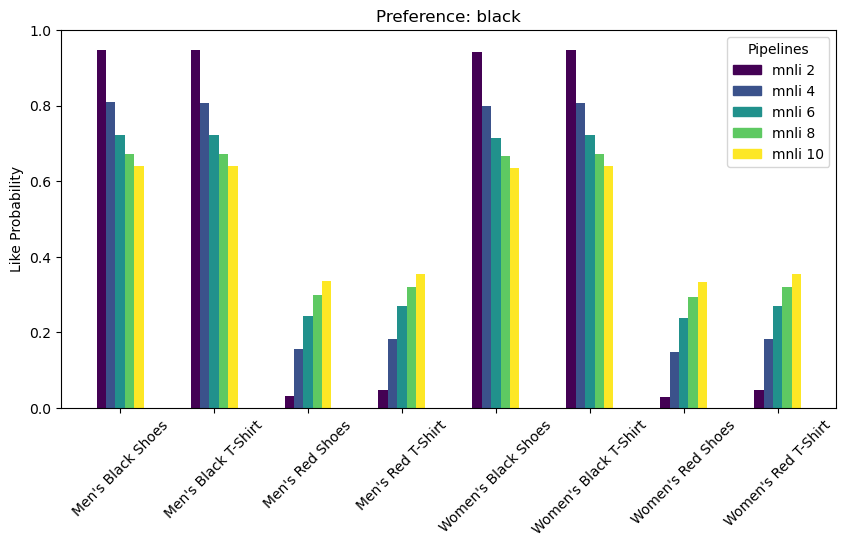

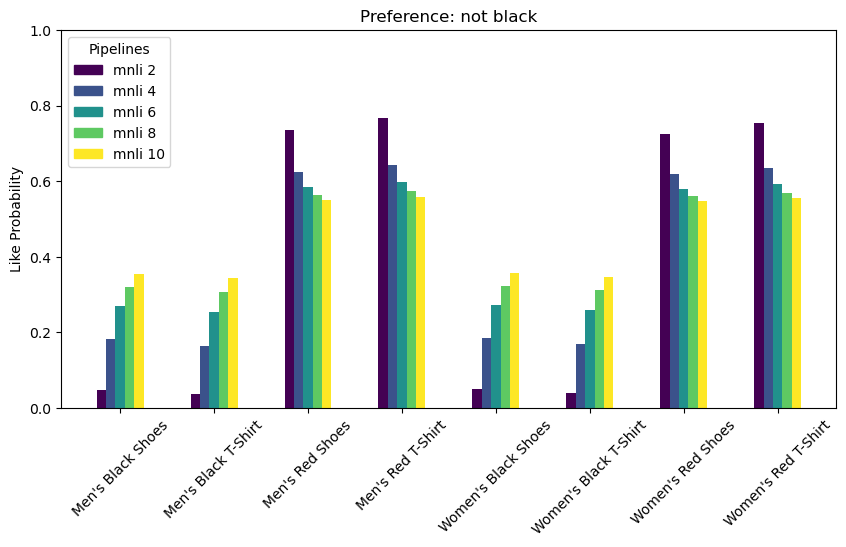

In [46]:
plot_entailment_pipeline(pipelines, easy_color_interactions, clothing, clothing_img_path)

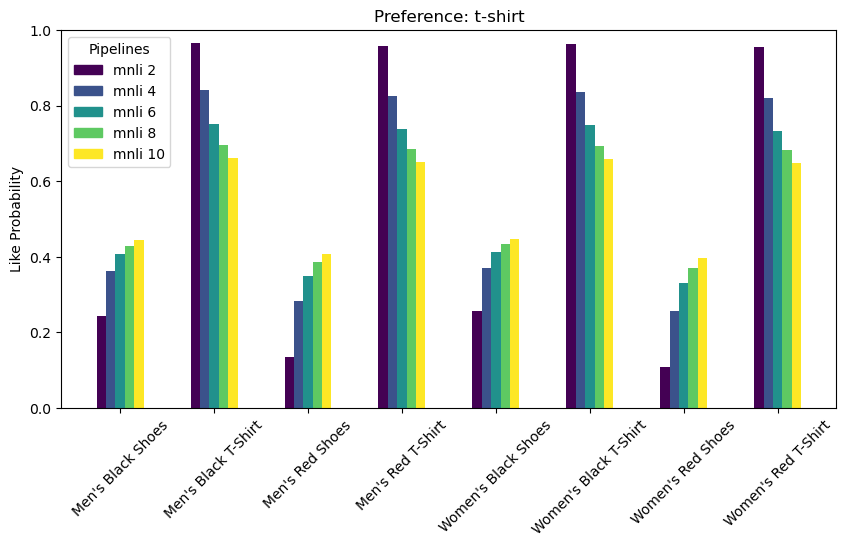

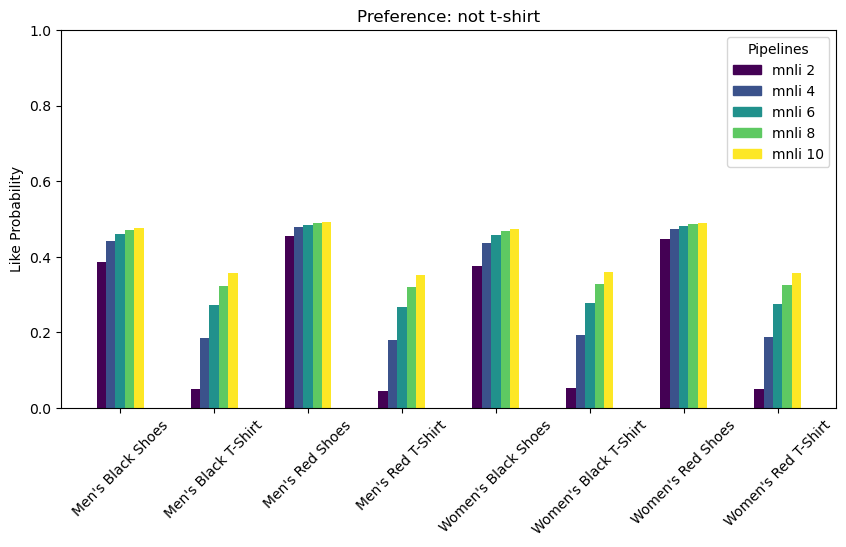

In [48]:
plot_entailment_pipeline(pipelines, easy_clothing_type_interactions, clothing, clothing_img_path)

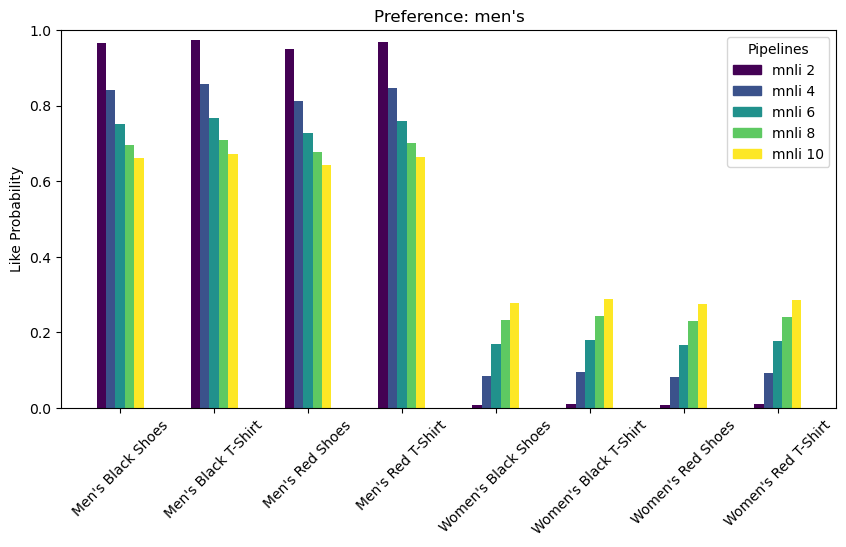

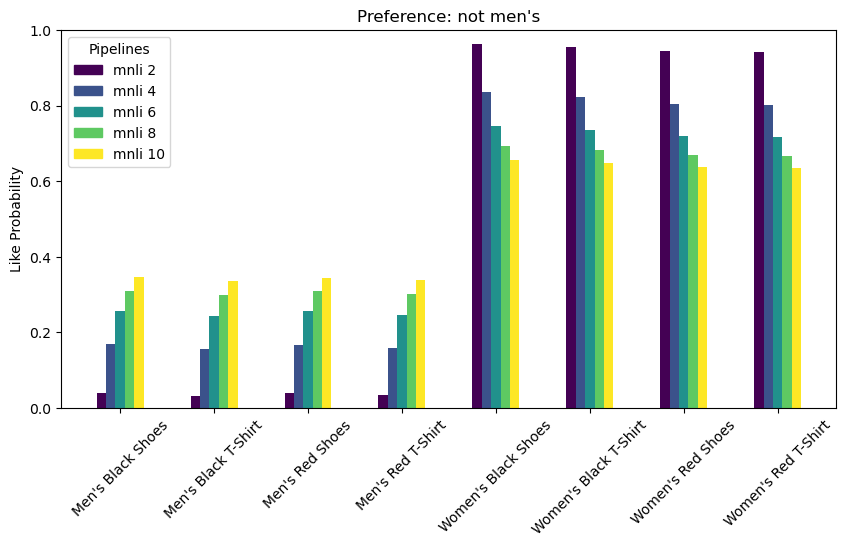

In [49]:
plot_entailment_pipeline(pipelines, easy_gender_interactions, clothing, clothing_img_path)

### FB mnli more experiments (neutral vs no neutral)


In [ ]:
hypotheses = ['not small red circle',
            'This item would be liked by someone who responed as follows: \n Query:  Are you looking for a small red circle? \n Response:  No',
            'Query:  Are you looking for a small red circle? \n Response:  No',
            'Men\'s blue shirt',
           'blue shirt',
             'blue',
             'Query: Are you looking for something blue? \nResponse: yes']
           
premises = ['large red circle', 'large red circle','large red circle','blue shirt','Men\'s blue shirt','Red Large Circle','Red Large Circle']

inputs = nli_tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt", max_length=nli_tokenizer.model_max_length)

# Ensure the tokenized inputs don't exceed the max length
if inputs.input_ids.size(1) > nli_tokenizer.model_max_length:
    print(f"Warning: One or more tokenized inputs exceed the max length of {max_length} and will be truncated.")

#no gpu use for notebook
#inputs = inputs.to(device)
    
with torch.no_grad():
    outputs = nli_model(**inputs)

#### Throwing away neutral:


In [ ]:
# as per: https://huggingface.co/facebook/bart-large-mnli
# throw away "neutral" (dim 1) and take the probability of
# "entailment" (2) as the probability of the label being true
entail_contr_logits = outputs[0][:,[0,2]]
entail_contr_probs  = torch.nn.functional.softmax(entail_contr_logits, dim=-1)

#entailment_probs = predictions[:, 2].tolist()
entail_contr_probs

#### Keeping neutral:


In [ ]:
all_probs = torch.nn.functional.softmax(outputs[0],dim=-1)
all_probs

In [ ]:
#Anton observation dec 12:
#logits are [contradicts, neutral, entails]

#Aspect negation format works OK
#-------------------------------
#premise = 'not small red circle'
#hypothesis = '''
#large red circle'''
#logits: [-0.8607, -0.2254,  1.5746]

#Raw query response format works bad
#-------------------------------
#premise = 'large red circle'
#hypothesis = '''
#This item would be liked by someone who responed as follows:
#Query:  Are you looking for a small red circle? \n Response:  No'''
#[ 2.7382, -1.1287, -2.2011]
#Anton observation Dec 12: neutral may only be output when the hypothesis is a generalization of the premise (e.g. P = soccer, H = world cup soccer)

#### Sentence-Transformer Cross Encoder

In [ ]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

In [72]:
test_CE_input =  [('not small red circle', 'large red circle'),
                  ('This item would be liked by someone who responed as follows: \n Query:  Are you looking for a small red circle? \n Response:  No','large red circle'),
                  ('Query:  Are you looking for a small red circle? \n Response:  No', 'large red circle'),
                  ('Men\'s blue shirt', 'blue shirt'),
                 ('blue shirt', 'Men\'s blue shirt'),
                 ('Blue Large Circle','not blue')]

output = ce_model.predict(test_CE_input)

torch.sigmoid(torch.from_numpy(output)).tolist()

[0.9460662007331848,
 6.547756493091583e-05,
 0.9145389795303345,
 0.728950560092926,
 0.9942330718040466,
 0.01334536261856556]

## Multiple Aspects

In [36]:
#format: { <aspect>/"not "+<aspect> : {query: <query>, response: <"Yes"/"No>, asepect: <aspect>}}
compound_color_gender_interactions = {
'black men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black not men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response': 'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black not men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
}

{'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }
{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' }

compound_type_color_interactions = {
't-shirt black' : [{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'}],
't-shirt not black' : [{'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'}],
'not t-shirt black' : [{'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'}],
'not t-shirt not black ' :[{'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'}],
}

compound_color_type_gender_interactions = {
'black t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black not t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'black not t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'yes','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'yes','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black not t-shirt men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'yes','aspect key': 'gender', 'aspect value': 'men\'s' }],
'not black not t-shirt not men\'s' : [{'query':'Are you looking for something black?', 'response':'no','aspect key': 'color', 'aspect value': 'black'},
                {'query':'Are you looking for a t-shirt?', 'response':'no','aspect key': 'clothing type', 'aspect value': 't-shirt' },
                {'query':'Are you looking for men\'s clothing?', 'response':'no','aspect key': 'gender', 'aspect value': 'men\'s' }],
}


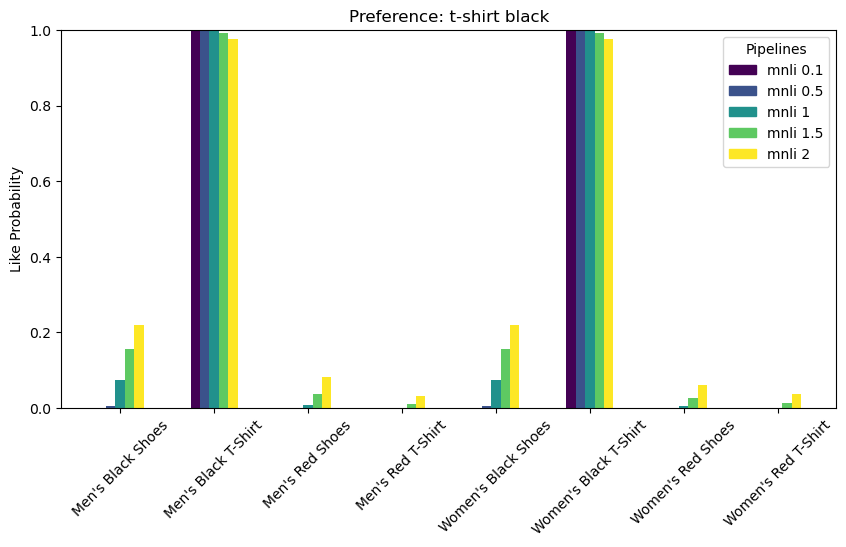

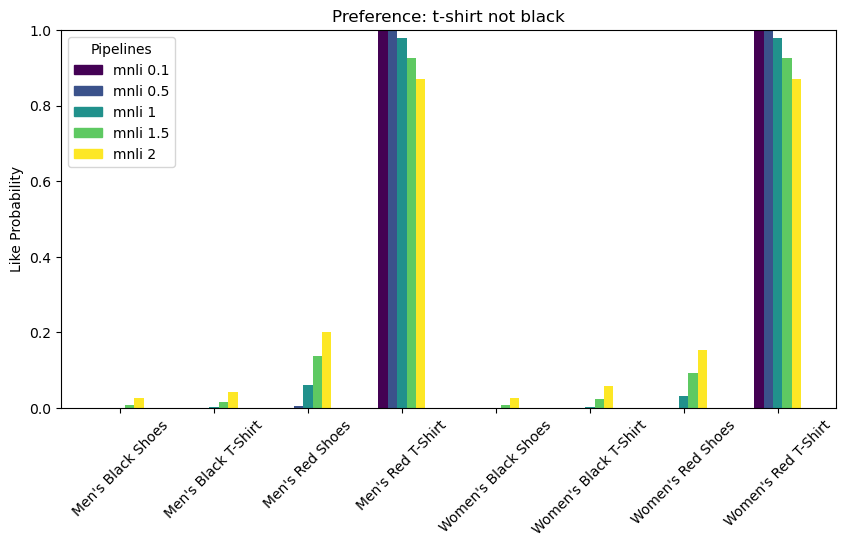

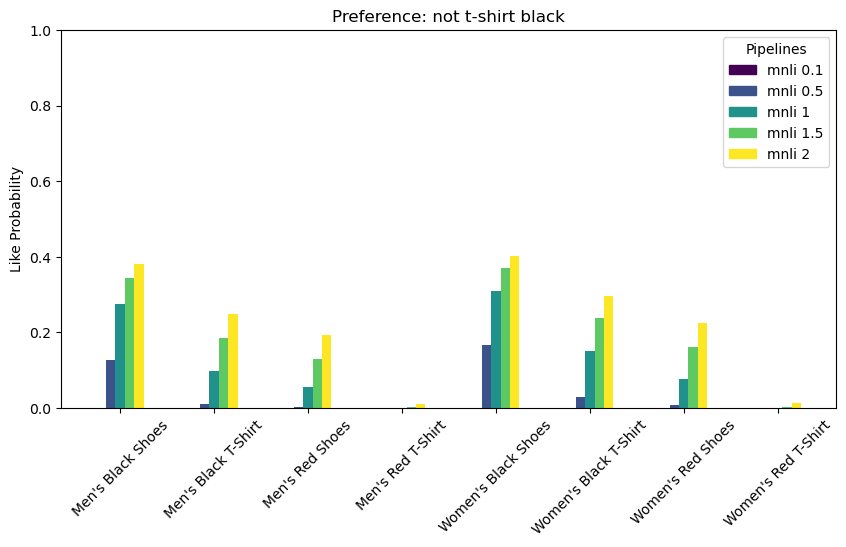

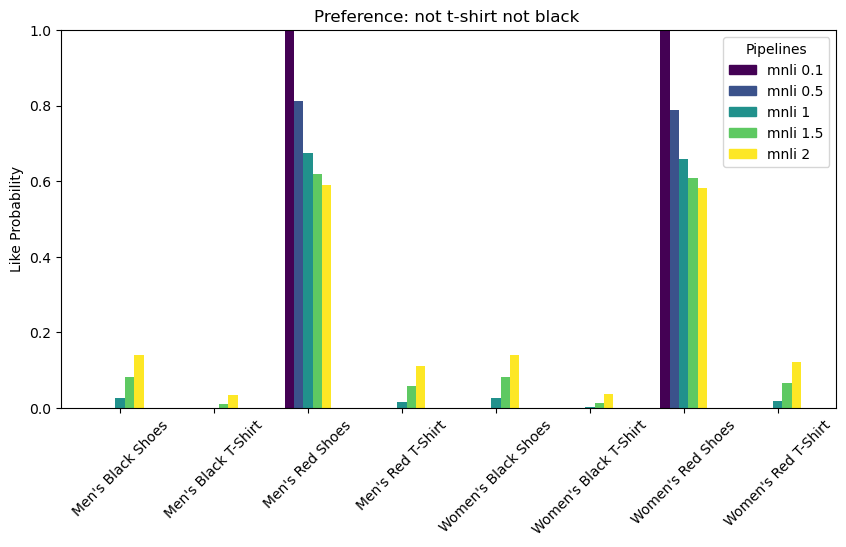

In [37]:
plot_entailment_pipeline(pipelines, compound_type_color_interactions, clothing, clothing_img_path)

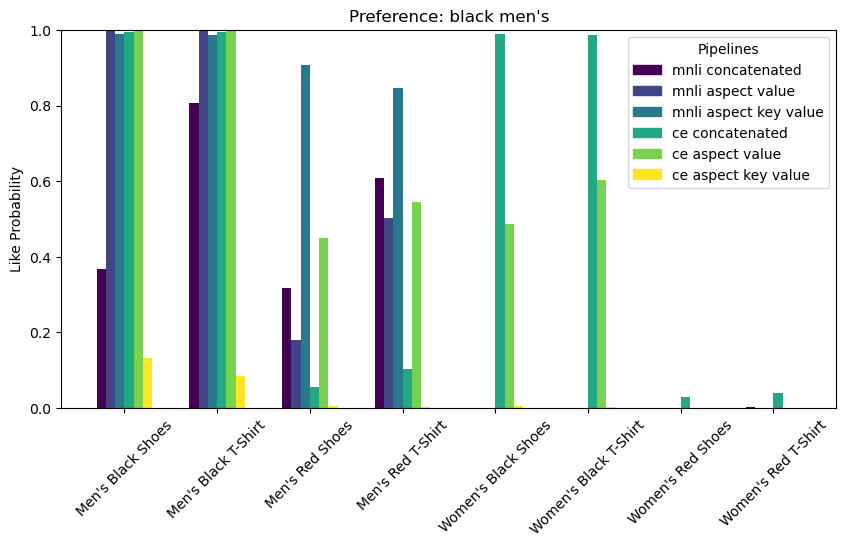

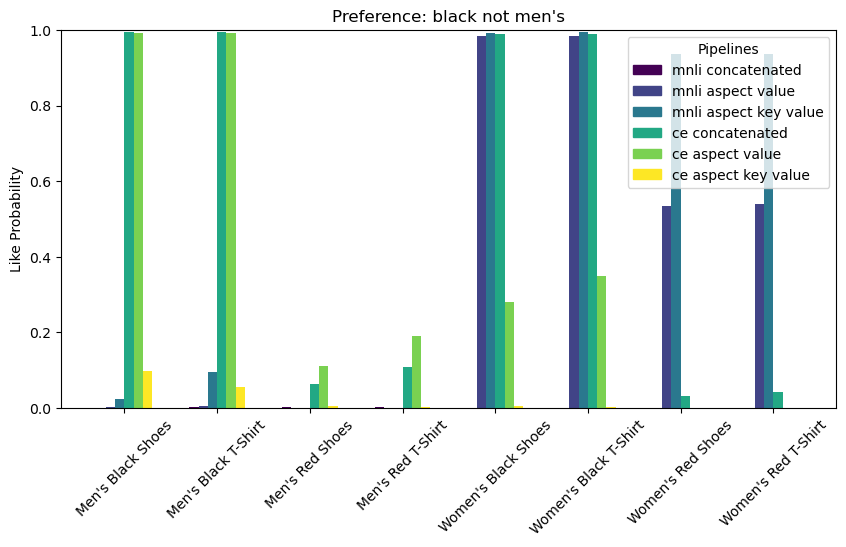

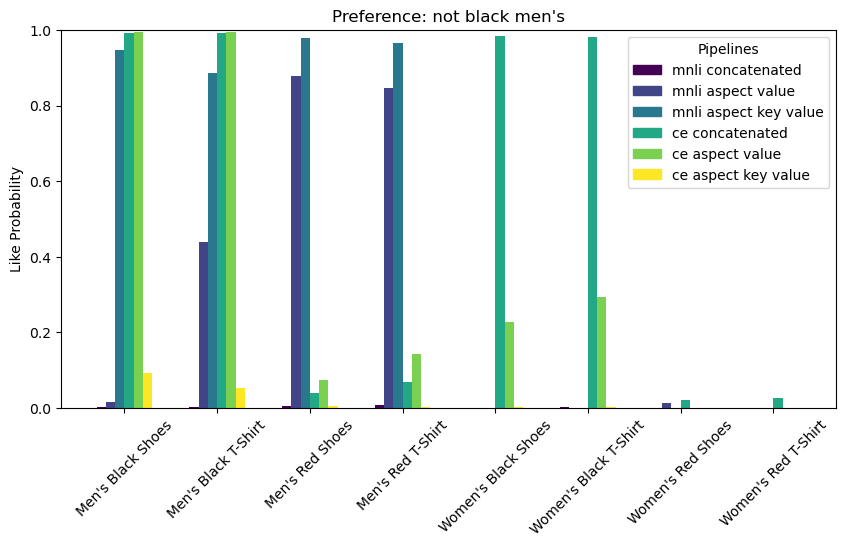

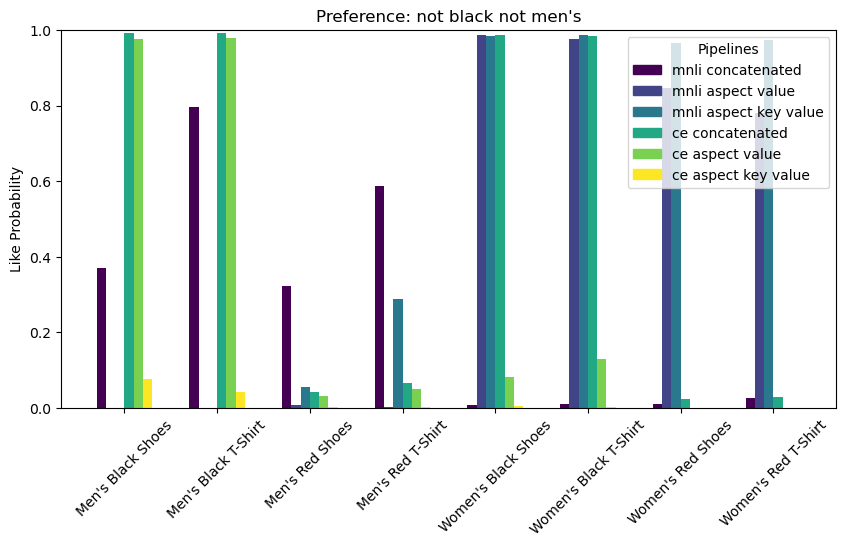

In [49]:
plot_entailment_pipeline(pipelines, compound_color_gender_interactions, clothing, clothing_img_path)

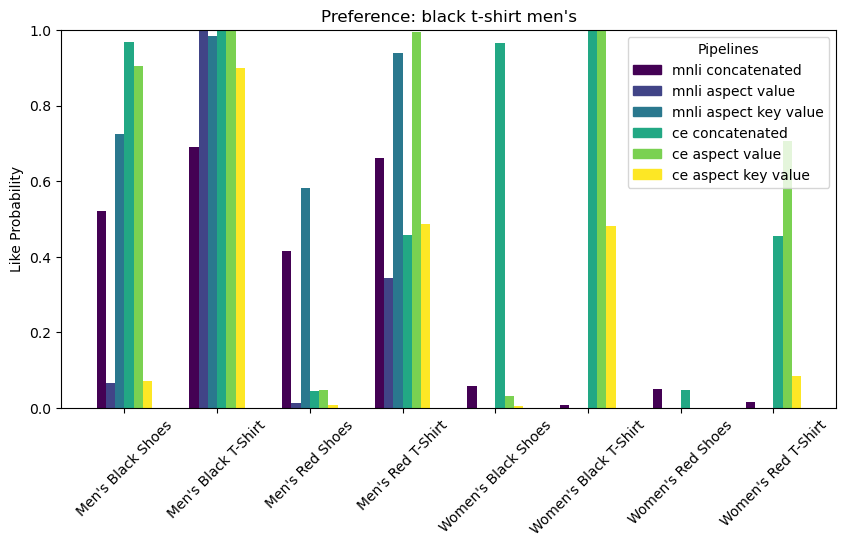

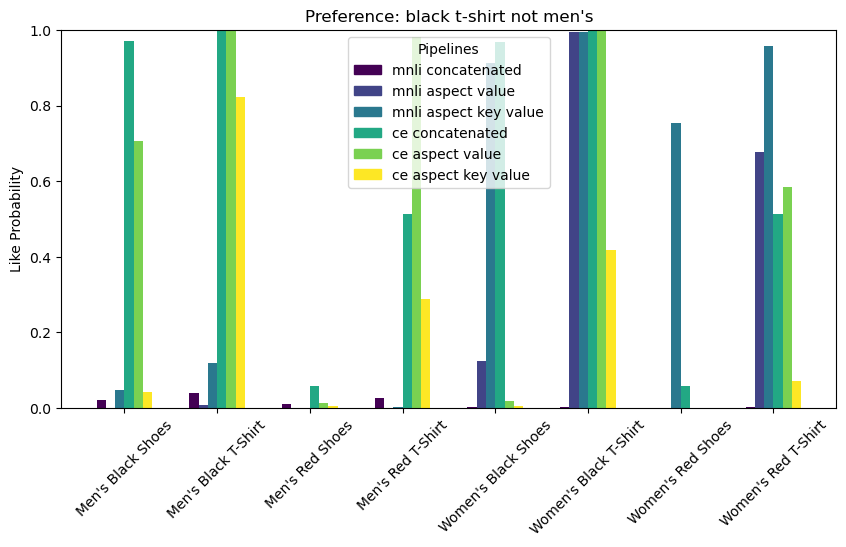

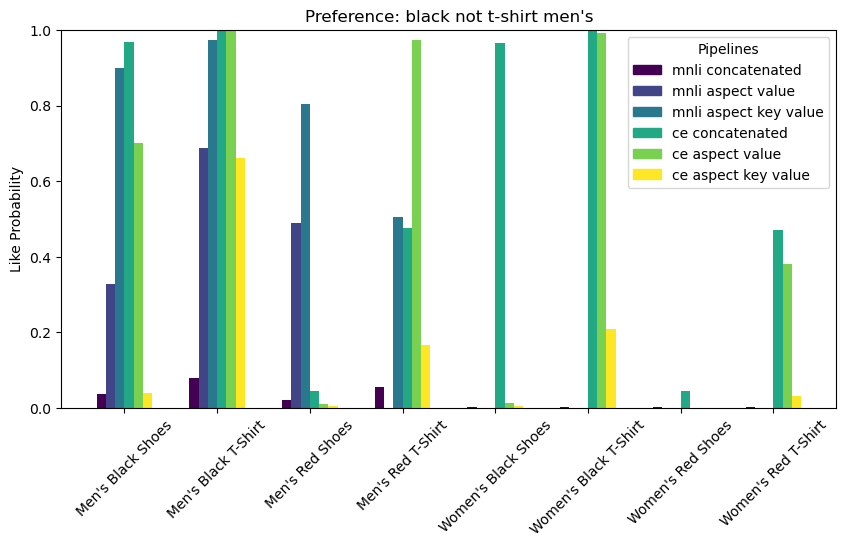

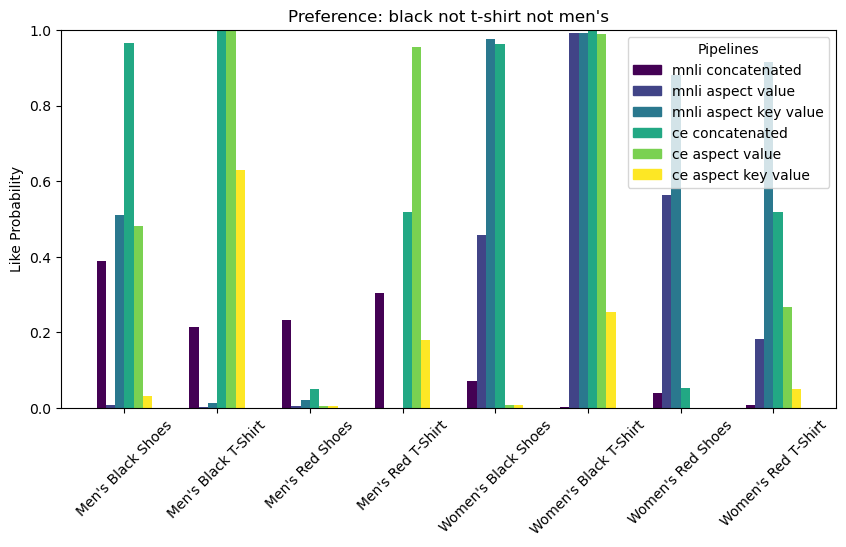

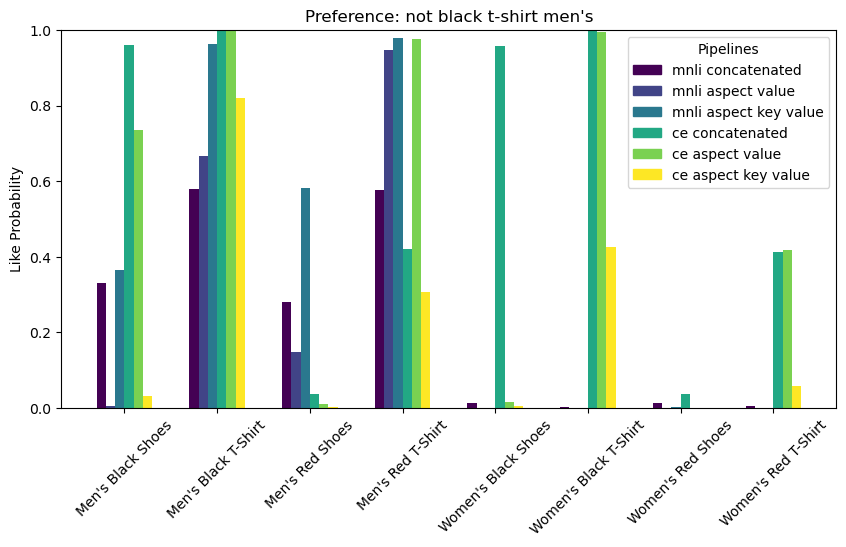

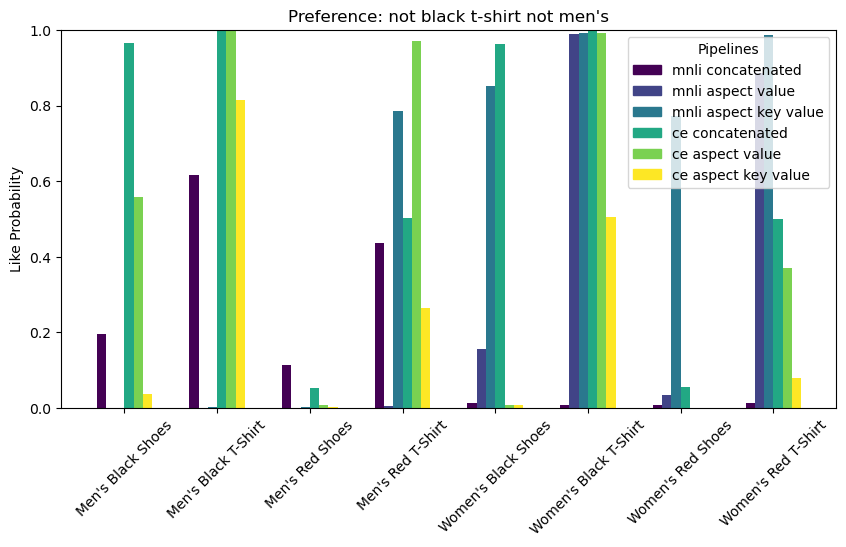

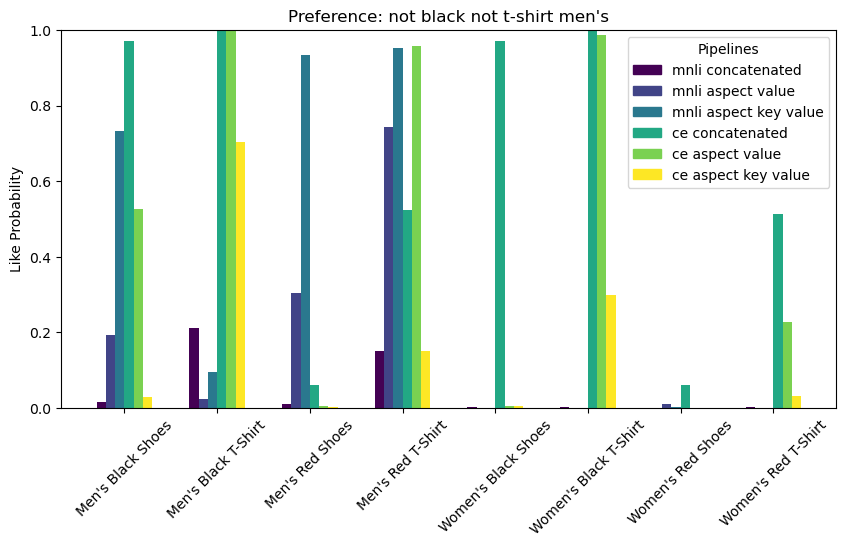

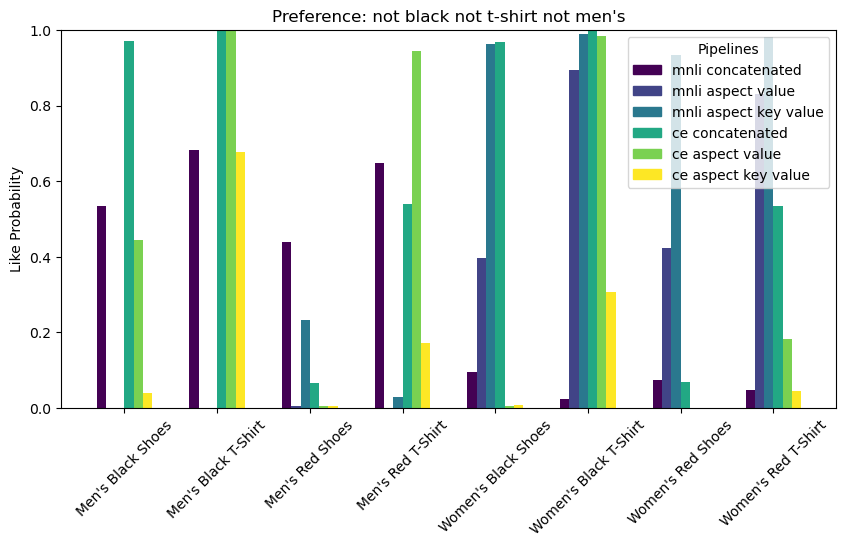

In [50]:
plot_entailment_pipeline(pipelines, compound_color_type_gender_interactions, clothing, clothing_img_path)

## MovieLens Testing

In [43]:
# Load in items
with open('data/movielens_16_trimmed.json') as f:
    movies = json.load(f)
movies

{'0': {'description': 'Heat (1995), Action, Crime, Thriller, imdb top 250, great acting, realistic action, suspense, Al Pacino, atmospheric, bank robbery, crime, Robert De Niro, tense, Val Kilmer, bank job, dialogue, heist, heist movie, long, Los Angeles',
  'name': 'Heat (1995)'},
 '1': {'description': 'Aladdin (1992), Adventure, Animation, Children, Comedy, Musical, Katottava, aftercreditsstinger, animal sidekick, animation, arab, arabian nights, cartoon, comedy, flying carpet, genie, love, magic, magic lamp, monkey, musical, parrot, princess',
  'name': 'Aladdin (1992)'},
 '2': {'description': 'Godfather, The (1972), Crime, Drama, italian mafia, italy, Mafia, Marlon Brando, masterpiece, imdb top 250, Oscar (Best Picture), based on a book, catchy theme, organized crime, visceral, 100 Greatest Movies, classic, great acting, mafia, Al Pacino, epic',
  'name': 'Godfather, The (1972)'},
 '3': {'description': 'Reservoir Dogs (1992), Crime, Mystery, Thriller, gangster, organized crime, vio

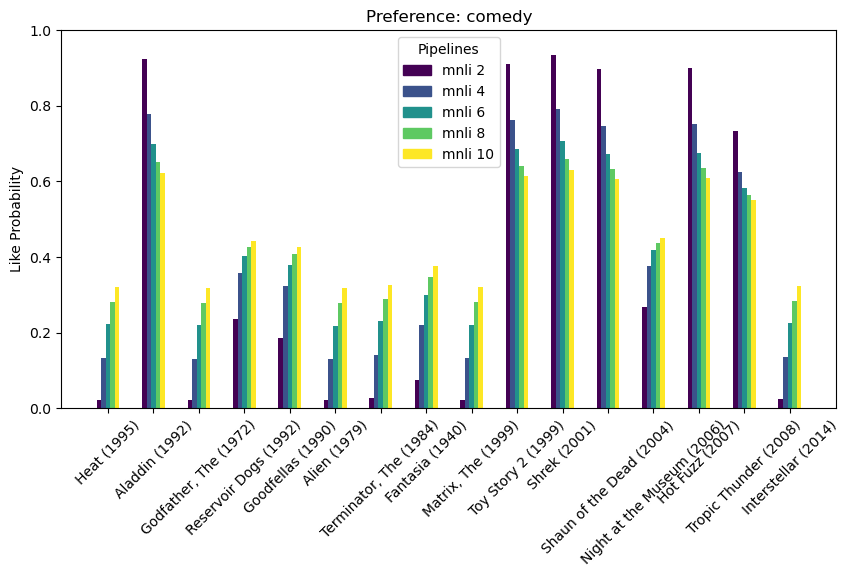

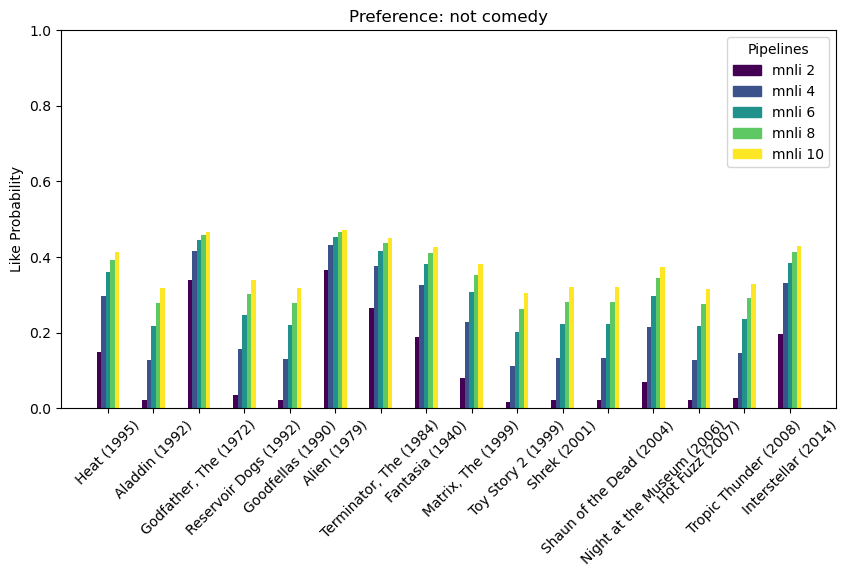

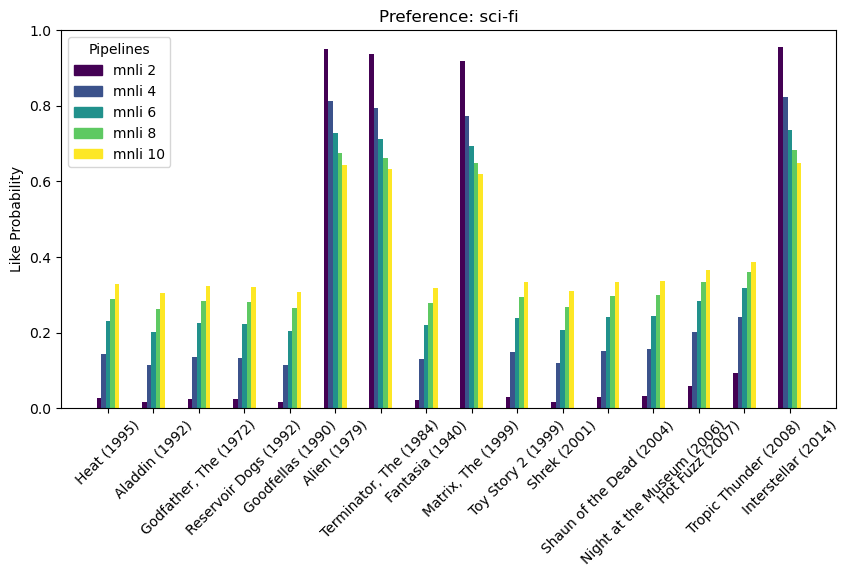

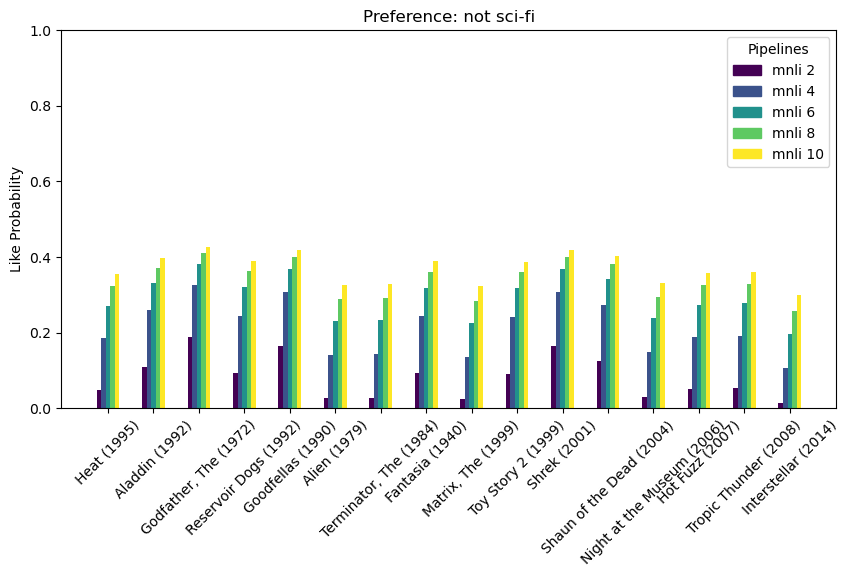

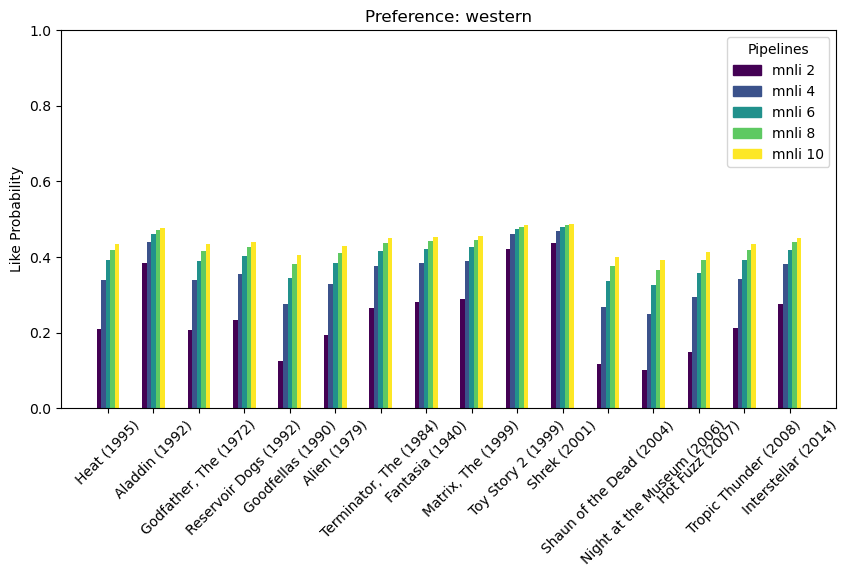

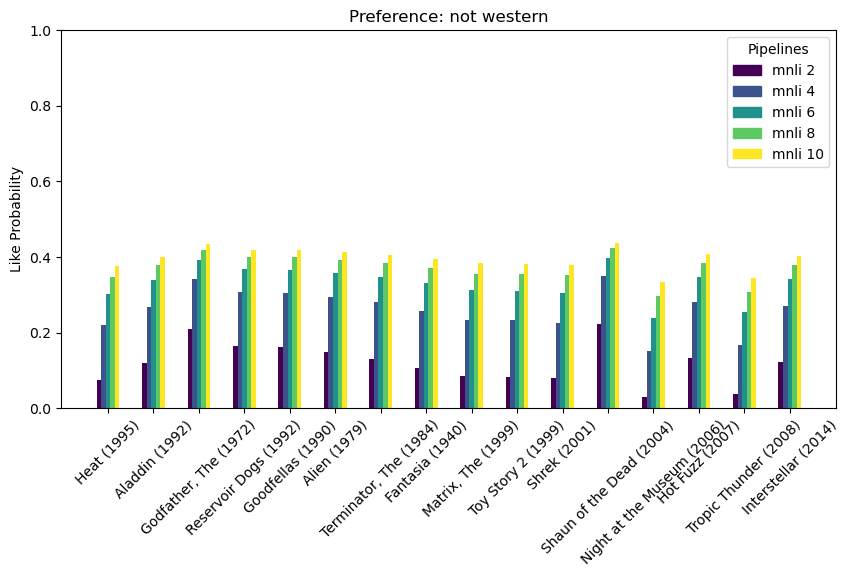

In [51]:
movie_genre_interactions = {
'comedy' : [{'query':'Do you like comedies?', 'response':'yes','aspect key': 'genre', 'aspect value': 'comedy' }],
'not comedy' : [{'query':'Do you like comedies?', 'response':'no','aspect key': 'genre', 'aspect value': 'comedy'}],
'sci-fi' : [{'query':'Do you like sci-fi?', 'response':'yes','aspect key': 'genre', 'aspect value': 'sci-fi' }],
'not sci-fi' : [{'query':'Do you like sci-fi?', 'response':'no','aspect key': 'genre', 'aspect value': 'sci-fi' }],
'western' : [{'query':'Do you like westerns?', 'response':'yes','aspect key': 'genre', 'aspect value': 'western' }],
'not western' : [{'query':'Do you like westerns?', 'response':'no','aspect key': 'genre', 'aspect value': 'western' }],
}

plot_entailment_pipeline(pipelines, movie_genre_interactions, movies, movies_img_path)

In [35]:
# Load in movies with titles
with open('data/movielens_2_titles.json') as f:
    movies_with_titles = json.load(f)
movies_with_titles

{'1214': {'description': 'Alien (1979)', 'name': 'Alien (1979)'},
 '1240': {'description': 'Terminator, The (1984)',
  'name': 'Terminator, The (1984)'},
 '2571': {'description': 'Matrix, The (1999)', 'name': 'Matrix, The (1999)'},
 '8874': {'description': 'Shaun of the Dead (2004)',
  'name': 'Shaun of the Dead (2004)'},
 '46972': {'description': 'Night at the Museum (2006)',
  'name': 'Night at the Museum (2006)'},
 '51255': {'description': 'Hot Fuzz (2007)', 'name': 'Hot Fuzz (2007)'},
 '61132': {'description': 'Tropic Thunder (2008)',
  'name': 'Tropic Thunder (2008)'},
 '109487': {'description': 'Interstellar (2014)',
  'name': 'Interstellar (2014)'}}

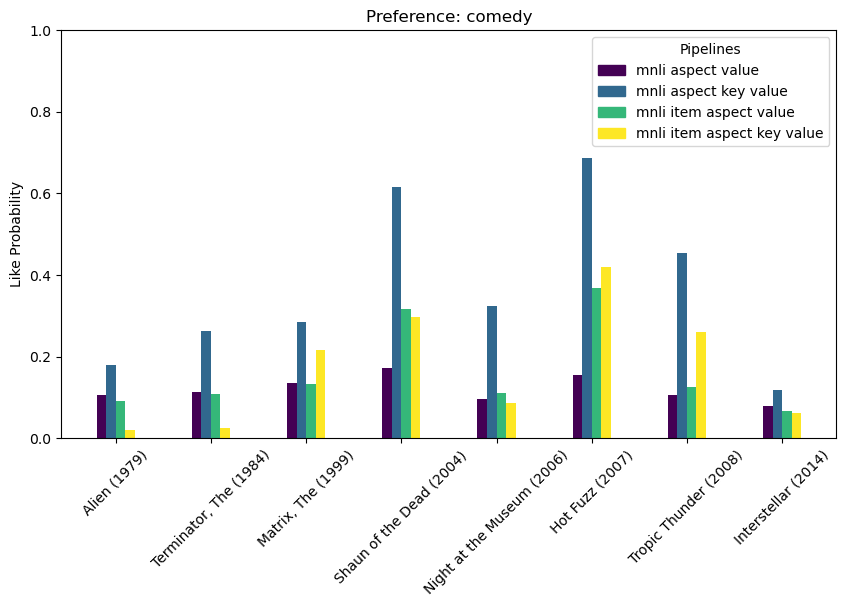

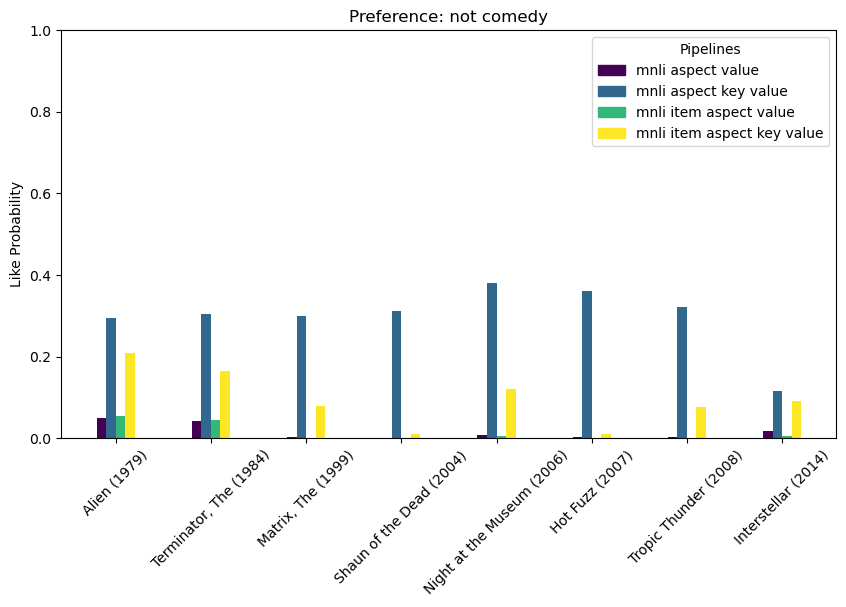

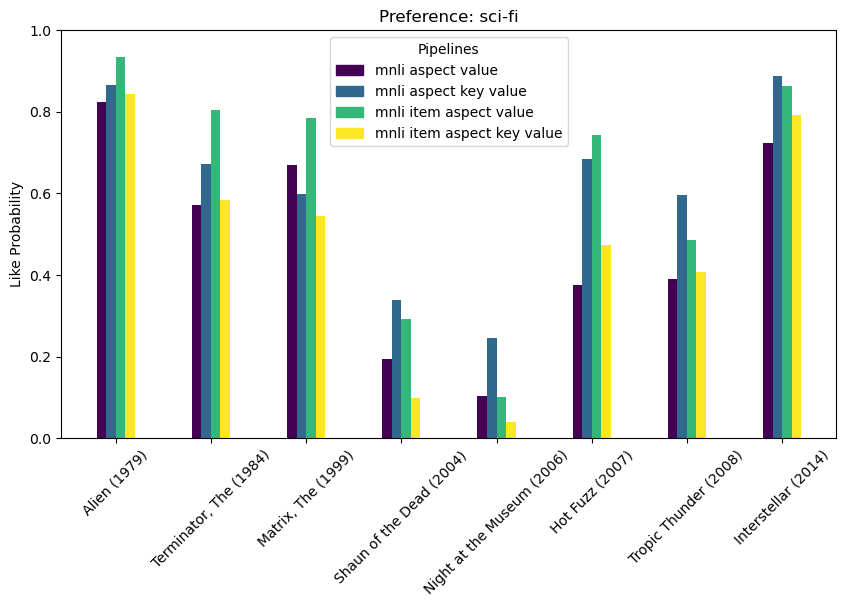

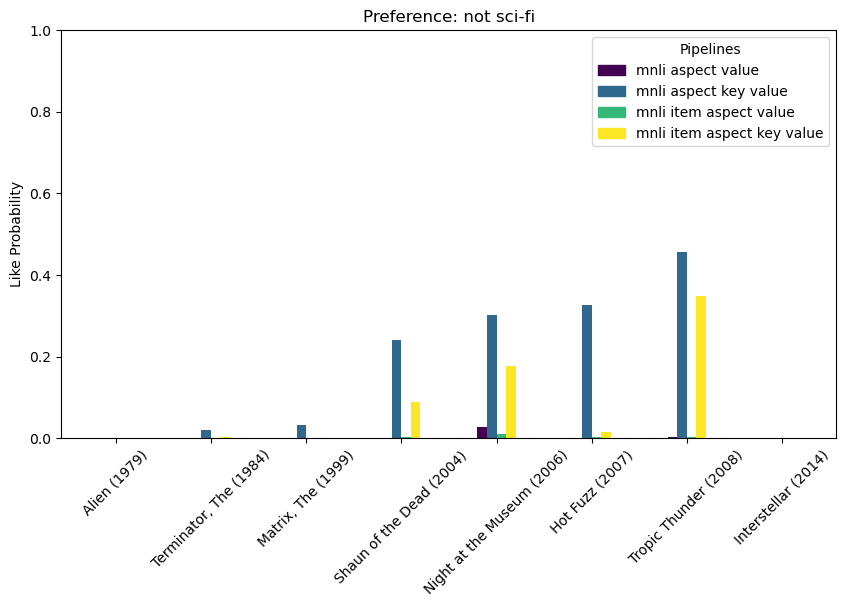

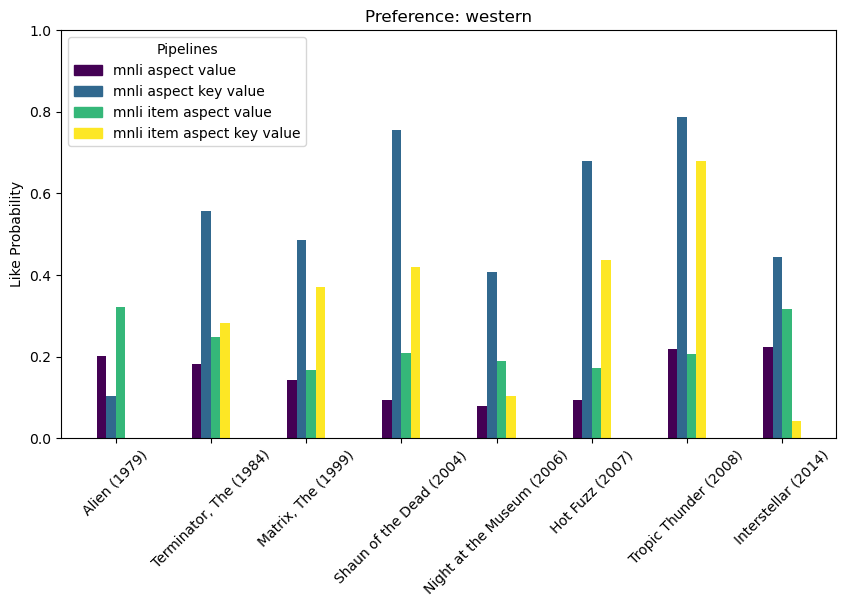

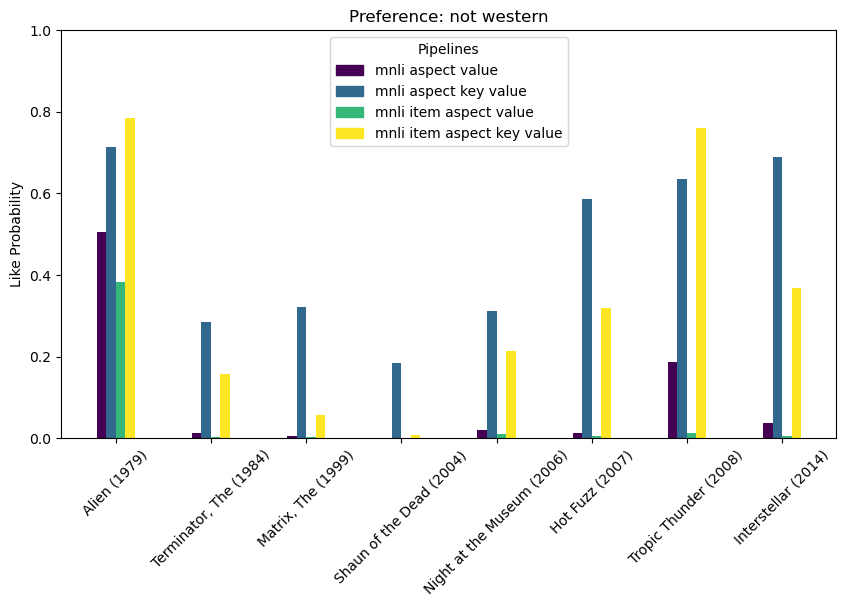

In [36]:
plot_entailment_pipeline(pipelines, movie_genre_interactions, movies_with_titles, movies_img_path)